# Data Science Challenge 2021 - Jane Holland

This kernel aims to predict car insurance cold call success. It shows data exploration, feature engineering, visualization and different classifier selection.

The kernel is split into 6 main sections: 
1. Viewing the data - what are we working with.
2. Cleaning the data - preprocessing the data we are working with.
3. Data Analysis and Visualisation - what trends and patterns we can see in the data.
4. Prepare Data for Machine Learning - change category columns into numerical data.
5. Machine Learning Classifiers - using different machine learning techniques to predict the cold call success
6. Testing the Trained Model - examine the model on the test data (CarInsurance_test.csv)

## Import necessary libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import itertools
from itertools import product

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Regression & Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import tree

#Metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

sns.set_theme(style="whitegrid")

# 1. Viewing the data

## Read in csv files and show first 5 rows

In [49]:
df_train = pd.read_csv('carInsurance_train.csv', sep=',')
df_test = pd.read_csv('carInsurance_test.csv', sep=',')
df_train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


## Display the number of rows and columns as a tuple 

In [50]:
df_train.shape

(4000, 19)

## Display information about dataframe; columns, datatypes, etc.

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

# 2. Cleaning the data (preprocessing)
This involves:
- removing any data that is not considered important.
- filling in missing data.
- checking for duplicates (and removing if present).
- converting datatypes to the correct datatype.
- dealing with outliers.

## Show any null values in dataframe
We will need to clean any NA values in the dataframe by either 1) dropping the column, or 2) filling in the missing data with the mode or the mean.

In [52]:
df_train.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

## Show any duplicates in dataframe

In [53]:
duplicates = df_train.duplicated()
print(duplicates.sum())

0


## Remove and fill columns
- As we are not conducting any time series on individuals, the Id column can be removed.
- The Outcome column has 3042/4000 missing values, so this column can also be dropped.
- The Job, Education, and Communication columns are missing only a small amount of data so we will fill them with the most common attributes.

In [54]:
# Drop ID (not sequential, independent) and Outcome (too much missing data) columns
df_train= df_train.drop(['Id'], axis=1)
df_train= df_train.drop(['Outcome'], axis=1)

# Fill NA values with the most common atttribute for each column
for column in ['Job', 'Education','Communication']:
        df_train[column] = df_train[column].fillna(df_train[column].mode()[0])

df_train.isnull().sum()

Age                 0
Job                 0
Marital             0
Education           0
Default             0
Balance             0
HHInsurance         0
CarLoan             0
Communication       0
LastContactDay      0
LastContactMonth    0
NoOfContacts        0
DaysPassed          0
PrevAttempts        0
CallStart           0
CallEnd             0
CarInsurance        0
dtype: int64

## Converting datatypes
The CallStart and CallEnd need to be changed from objects to the time format.

In [55]:
# Conver to time datatype
df_train[['CallStart','CallEnd']]=df_train[['CallStart','CallEnd']].astype('datetime64[ns]')

# While we are dealing with the time attributes we will create a new column called Total Call Duration.

#Total Call Duration
df_train['CallDuration']=df_train['CallEnd']-df_train['CallStart']

# To make the CallDuration more comprehensible, we will convert it to seconds (convert minutes and add on remaining seconds)
df_train['CallDuration']=df_train['CallDuration'].dt.components['minutes']*60 + df_train['CallDuration'].dt.components['seconds']


## Taking a closer look at the string objects in dataframe

In [56]:
df_train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth
count,4000,4000,4000,4000,4000
unique,11,3,3,2,12
top,management,married,secondary,cellular,may
freq,912,2304,2157,3733,1049


## Do the same with the numerical datatypes

In [57]:
df_train.describe(datetime_is_numeric=True)

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance,CallDuration
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000,4000,4000.000000,4000.000000
mean,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,2021-06-04 13:32:04.683749888,2021-06-04 13:37:55.527749888,0.401000,350.844000
min,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,2021-06-04 09:00:00,2021-06-04 09:02:20,0.000000,5.000000
25%,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,2021-06-04 11:14:11,2021-06-04 11:20:02,0.000000,126.000000
50%,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,2021-06-04 13:36:13,2021-06-04 13:40:45,0.000000,232.000000
75%,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,2021-06-04 15:47:03.750000128,2021-06-04 15:53:06.750000128,1.000000,460.000000
max,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,2021-06-04 17:59:58,2021-06-04 18:25:31,1.000000,3253.000000
std,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,NaN,NaN,0.490162,342.236576


## Handling the outliers
In the above describtion we can see that the mean of the balance is 1532, but the min value is -3058 and the max value is 98417. This seems like a large range so we will take a closer look and use a boxplot to see what the spread is like.

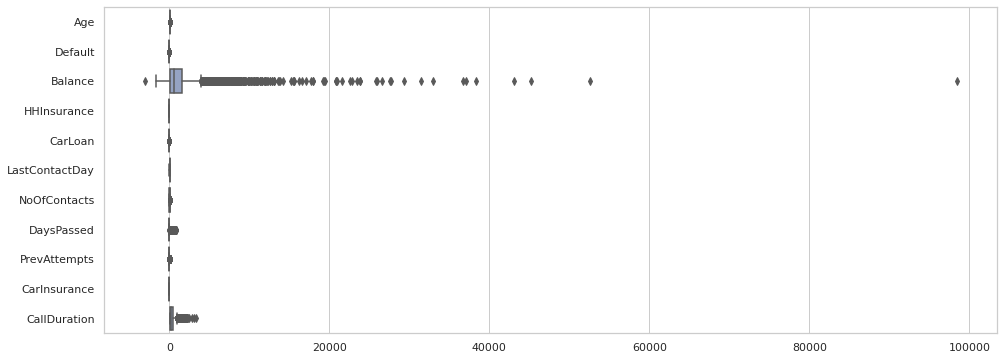

In [58]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=df_train, orient="h", palette="Set2")

As suspected the Balance column has some outliers. we will create a function to remove the outliers and only use the values betwen the 1st and 3rd quartile

In [59]:
# remove outliers in Balance column
def remove_outliers(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    # Use interquartile range (IQR) to find outliers.
    IQR=Q3-Q1
    #  Values lower than the lower boundary are outliers.
    lower_range=Q1-(1.5*IQR)
    #  Values greater than the upper boundary are outliers.
    upper_range=Q3+(1.5*IQR)
    return lower_range, upper_range

In [60]:
# Redefining the Balance column - removing the outliers
low_bal, upp_bal = remove_outliers(df_train['Balance'])
df_train['Balance']=np.where(df_train['Balance'] > upp_bal, upp_bal, df_train['Balance'])
df_train['Balance']=np.where(df_train['Balance'] < low_bal, low_bal, df_train['Balance'])

# 3. Data Analysis and Visualisation
Here we will explore the data in more detail and visualise any significant observations.

## Data Correlation

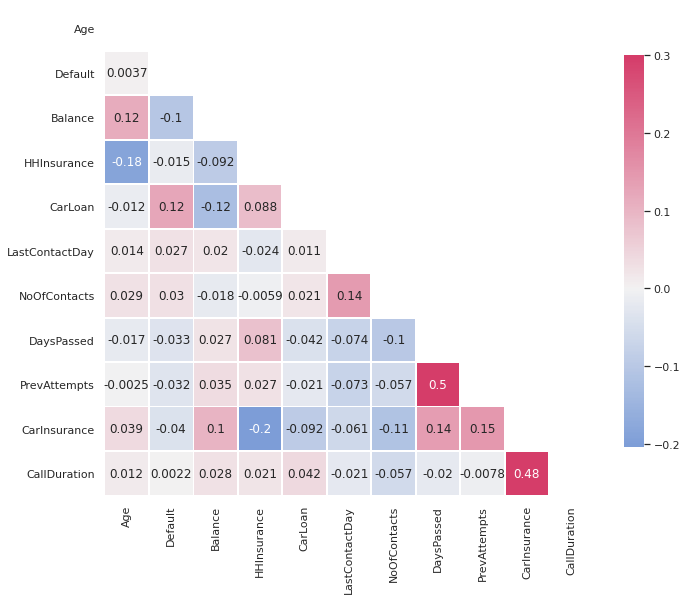

In [61]:
# Display the correlated data as a heatmap - this will show the positive and negative correlations clearly.
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 0, as_cmap=True)

sns.heatmap(corr, annot=True, fmt=".2", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .8})

From this heatmap correlation matrix we can see that:
 - There are Strong Positive correlations between the CarInsurance and CallDuration, as well as PrevAttempts and DaysPassed. Negative correlations can be seen with the LastContactDay and CarInsurance, as well as the Age and  HHinsurance.

- Perhaps a longer CallDuration increases the odds of subscribing car insurance.

- Furthermore, the more times an individual is contacted, the less likely they are to subscribe to car insurance.

- Other attributes are fairly independent.

## Looking more closely at the  pairwise relationships in a dataset

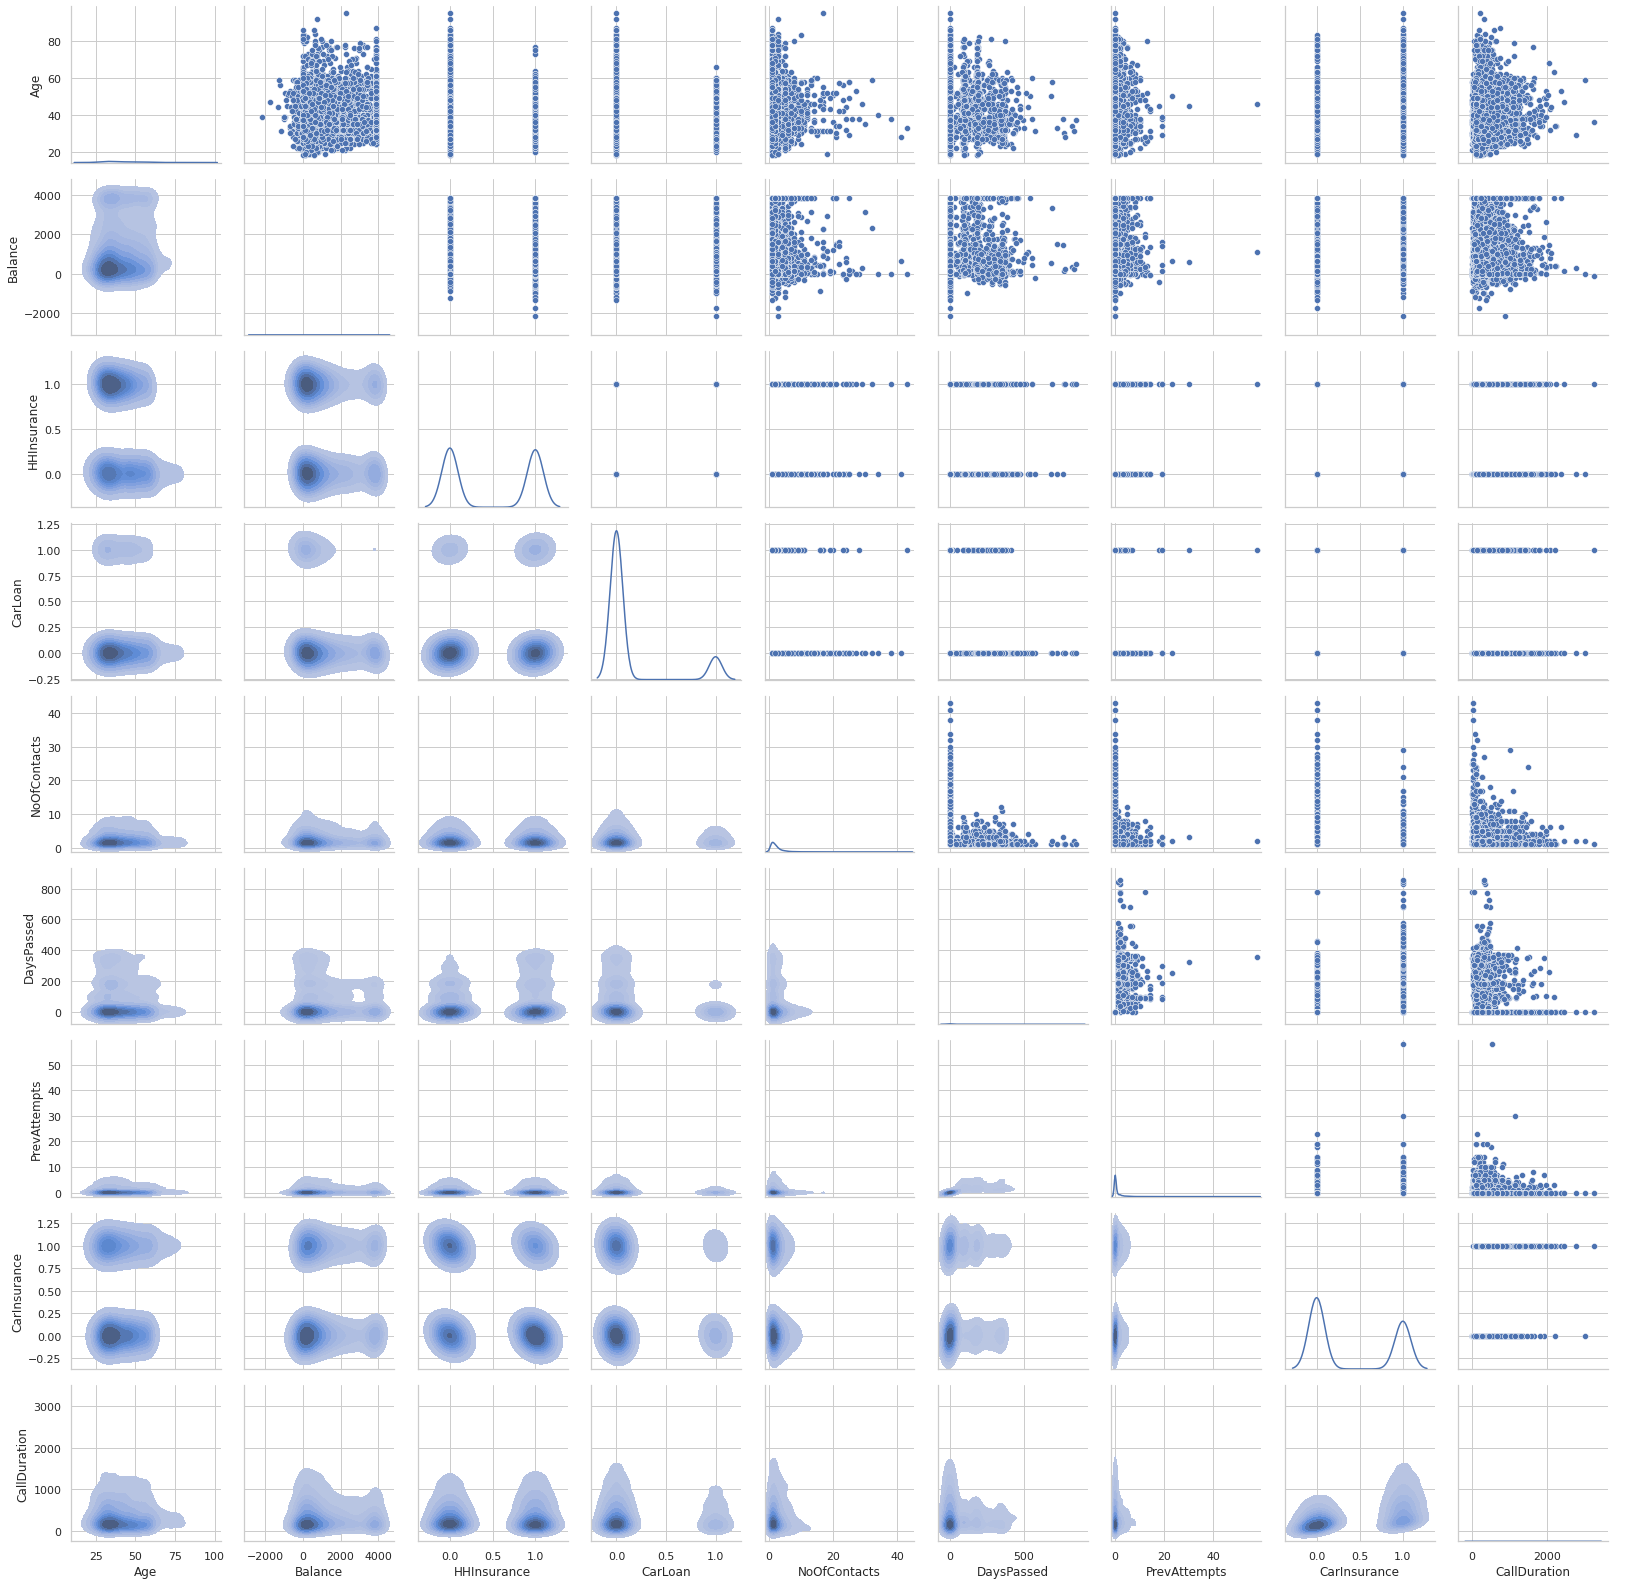

In [62]:
# Plot some of the more important attribute features
df_pair_feats = ['Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts', 'CarInsurance', 'CallDuration']
g = sns.PairGrid(df_train[df_pair_feats])  
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot)
g.add_legend()

Here we can see a few different observations:
- Younger people (<40) are less likely to have a car loan or car insurance subscribed. They are more likely to have house insurance and have a smaller balance.

- People with house insurance are less likely to have car insurance subscribed.

- The longer the Call Duration the more likely car insurance will be subscribed.

- The more frequently the number of times contacted during this campaign, the less likely that car insurance will be subscribed to the individual.

- The more previous attempts in the previous campaign, the more likely of subscribing insurance.

## Category Analysis and Visualisation

In [63]:
# Display the number and percentage of jobs that have car insurance subscribed
job_insured=pd.crosstab(df_train['Job'],df_train['CarInsurance'],colnames=['Car Insurance'])
job_insured['% with Car Insurance']=round(job_insured[1]/(job_insured[0]+job_insured[1])*100,2)
job_insured

Car Insurance,0,1,% with Car Insurance
Job,,,
admin.,274,185,40.31
blue-collar,540,219,28.85
entrepreneur,86,35,28.93
housemaid,72,37,33.94
management,511,401,43.97
retired,103,146,58.63
self-employed,86,54,38.57
services,218,112,33.94
student,44,87,66.41


In [64]:
# Display the number and percentage of different marital statuses that have car insurance subscribed
marital_insured=pd.crosstab(df_train['Marital'],df_train['CarInsurance'],colnames=['Car Insurance'])
marital_insured['% with Car Insurance']=round(marital_insured[1]/(marital_insured[0]+marital_insured[1])*100,2)
marital_insured

Car Insurance,0,1,% with Car Insurance
Marital,,,
divorced,273,210,43.48
married,1471,833,36.15
single,652,561,46.25


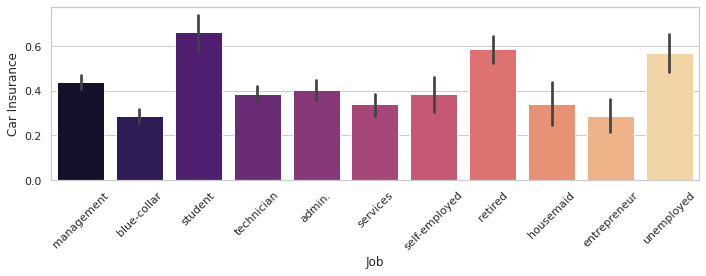

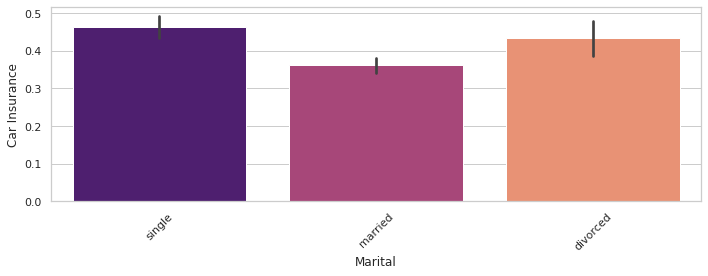

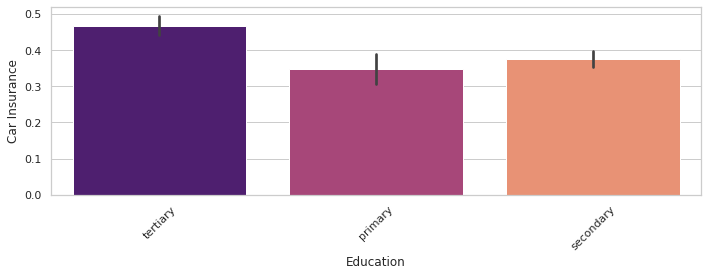

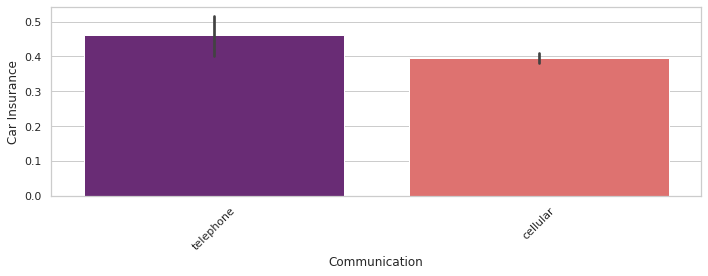

In [65]:
# Plot the amount of catergory features that have car insurance subscribed
df_category_feats = df_train[['Job','Marital','Education','Communication']]

for feature in df_category_feats:
    plt.figure(figsize=(10,4))
    sns.barplot(x=feature, y='CarInsurance', data= df_train, palette='magma') 
    plt.xticks(rotation=45)
    plt.ylabel('Car Insurance')
    plt.tight_layout()

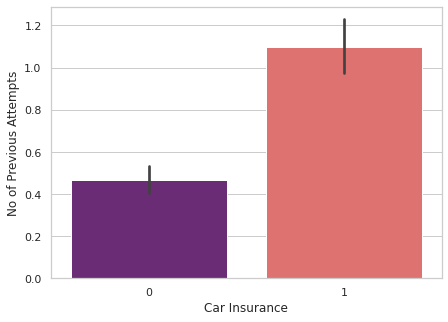

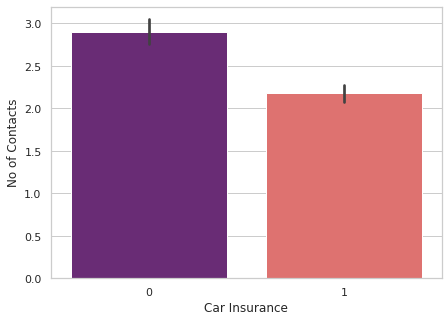

In [66]:
# Plotting the previous campaign (PrevAttempts) vs the current campaign (NoOfContacts)

# Plot how the number of previous attempts affects the outcome of car insurance subscribtion
plt.figure(figsize=(7,5))
sns.barplot( x='CarInsurance', y='PrevAttempts', data=df_train, palette='magma')
plt.ylabel('No of Previous Attempts')
plt.xlabel('Car Insurance')
plt.show()

# Plot how the number of contacts affects the outcome of car insurance subscribtion
plt.figure(figsize=(7,5))
sns.barplot( x='CarInsurance', y='NoOfContacts', data=df_train, palette='magma')
plt.ylabel('No of Contacts')
plt.xlabel('Car Insurance')
plt.show()

### Feature Engingeering
By using feature engingeering we can create more features that can be further analysed as well as for grouping attributes.

The Balance, Age, LastContactDay, and CallStart attributes are good examples of attributes to discretise it into equal-sized buckets. This produces a Category object where each quantile or bracket has a membership for each datapoint.

In [67]:
# Here I will create the bins and give each one a label.
# For e.g. if your balance -500 you will be in the 'Negative Balance' bracket

# Whats the min and max balances - this can inform decision on how many bins to use
print("Train:", df_train['Balance'].min(), df_train['Balance'].max())
print("Test:", df_test['Balance'].min(), df_test['Balance'].max()) # outliers here, dealt with later one

# Create and label bins
train_bal_bins= [-3000,0,1295,2590,3885]
train_bal_labels = ['Negative Balance','Low','Mid','High']

# Create a new column 'BalanceBracket' that shows the balance groups
df_train['BalanceBracket'] = pd.cut(df_train['Balance'], bins=train_bal_bins, labels=train_bal_labels, right=False, include_lowest=True)

# Display the number and percentage of different balance brackets that have car insurance subscribed
balance_insured=pd.crosstab(df_train['BalanceBracket'],df_train['CarInsurance'],colnames=['Car Insurance'])
balance_insured['% with Car Insurance']=round(balance_insured[1]/(balance_insured[0]+balance_insured[1])*100,2)
balance_insured

Train: -2151.0 3881.0
Test: -1980 41630


Car Insurance,0,1,% with Car Insurance
BalanceBracket,,,
Negative Balance,207,58,21.89
Low,1571,995,38.78
Mid,270,245,47.57
High,348,306,46.79


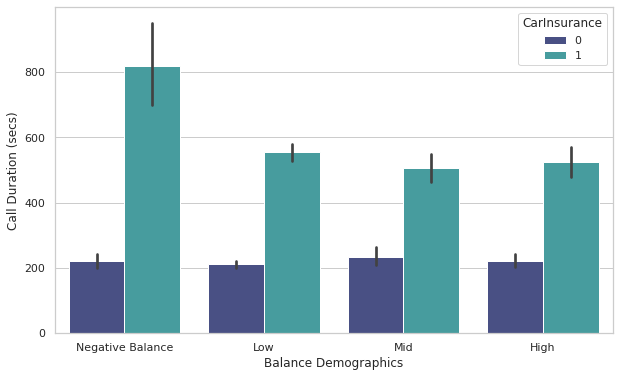

In [68]:
# Plotting how the call duration affects the likelyhood of subscribing to car insurance
# for different balance groups

plt.figure(figsize=(10,6))
sns.barplot(x='BalanceBracket', y='CallDuration', hue='CarInsurance', data=df_train, palette='mako')
plt.ylabel('Call Duration (secs)')
plt.xlabel('Balance Demographics')
plt.show()

In [69]:
# For the age brackets I chose intervals of 10 in order to make the data more clear

# Create the bins and give each one a label.
train_age_bins= [18,21,31,41,51,61,71,81,91,101]
train_age_labels = ['18-21','21-30','31-40','41-50','51-60','61-70','71-80','81-90', '90+']

# Create a new column 'AgeBracket' that shows the age groups
df_train['AgeBracket'] = pd.cut(df_train['Age'], bins=train_age_bins, labels=train_age_labels, right=False, include_lowest=True)

# Display the number and percentage of different age brackets that have car insurance subscribed
age_insured=pd.crosstab(df_train['AgeBracket'],df_train['CarInsurance'],colnames=['Car Insurance'])
age_insured['% with Car Insurance']=round(age_insured[1]/(age_insured[0]+age_insured[1])*100,2)
age_insured

Car Insurance,0,1,% with Car Insurance
AgeBracket,,,
18-21,7,16,69.57
21-30,342,313,47.79
31-40,955,544,36.29
41-50,618,331,34.88
51-60,434,250,36.55
61-70,21,95,81.90
71-80,16,45,73.77
81-90,3,8,72.73
90+,0,2,100.00


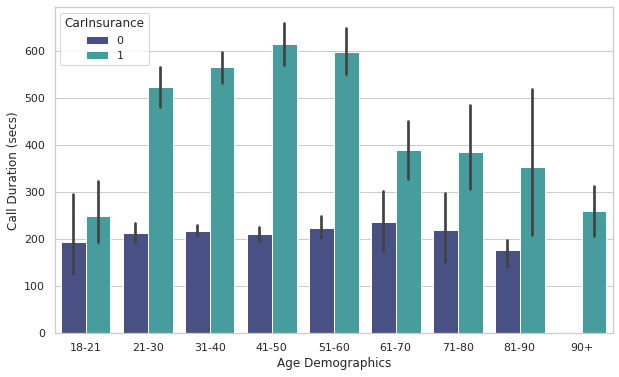

In [70]:
# Plotting how the call duration affects the likelyhood of subscribing to car insurance
# for different age demographics

plt.figure(figsize=(10,6))
sns.barplot(x='AgeBracket', y='CallDuration', hue='CarInsurance', data=df_train, palette='mako')
plt.ylabel('Call Duration (secs)')
plt.xlabel('Age Demographics')
plt.show()

In [71]:
# For the LastContactDay brackets I chose every 11 days to make the data more clear

# Create the bins and give each one a label.
train_day_bins= [0,10,21,32]
train_day_labels = ['Start','Middle','End']

# Create a new column 'DayBracket' that shows the age groups
df_train['DayBracket'] = pd.cut(df_train['LastContactDay'], bins=train_day_bins, labels=train_day_labels, right=False, include_lowest=True)

# Display the number and percentage of different contact day brackets that have car insurance subscribed
day_insured=pd.crosstab(df_train['DayBracket'],df_train['CarInsurance'],colnames=['Car Insurance'])
day_insured['% with Car Insurance']=round(day_insured[1]/(day_insured[0]+day_insured[1])*100,2)
day_insured


Car Insurance,0,1,% with Car Insurance
DayBracket,,,
Start,670,487,42.09
Middle,1005,660,39.64
End,721,457,38.79


<function matplotlib.pyplot.show(*args, **kw)>

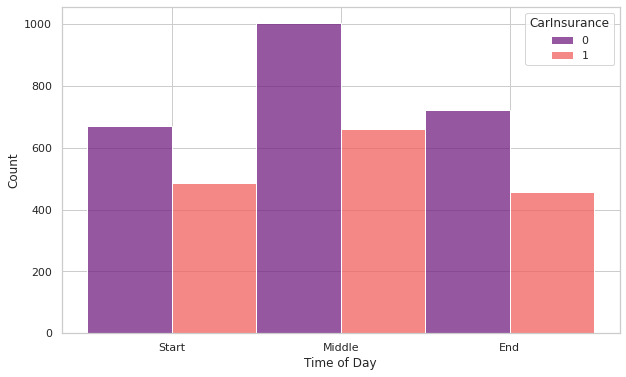

In [72]:
# Plotting how the time of the month affects the likelyhood of subscribing to car insurance
# for different age demographics

plt.figure(figsize=(10,6))
sns.histplot(x='DayBracket', hue='CarInsurance', data=df_train, multiple="dodge", palette='magma')
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.show

In [73]:
# Get the working hours for calls
print(df_train["CallStart"].dt.time.min(), df_train["CallStart"].dt.time.max())

# Based on the working hours (9am-6pm), I chose morning (9am-12), afternoon (12pm-3pm), and evening (3pm-6pm)
# day brackets.
# Create the bins and give each one a label.

df_train['TimeBracket']=pd.cut(df_train["CallStart"].dt.hour,
               [9,12,15,24],
               labels=['Morning','Afternoon','Evening'],
               right=False, include_lowest=True)

# Display the number and percentage of different contact day brackets that have car insurance subscribed
time_insured=pd.crosstab(df_train['TimeBracket'],df_train['CarInsurance'],colnames=['Car Insurance'])
time_insured['% with Car Insurance']=round(time_insured[1]/(time_insured[0]+time_insured[1])*100,2)
time_insured


09:00:00 17:59:58


Car Insurance,0,1,% with Car Insurance
TimeBracket,,,
Morning,763,521,40.58
Afternoon,847,518,37.95
Evening,786,565,41.82


<function matplotlib.pyplot.show(*args, **kw)>

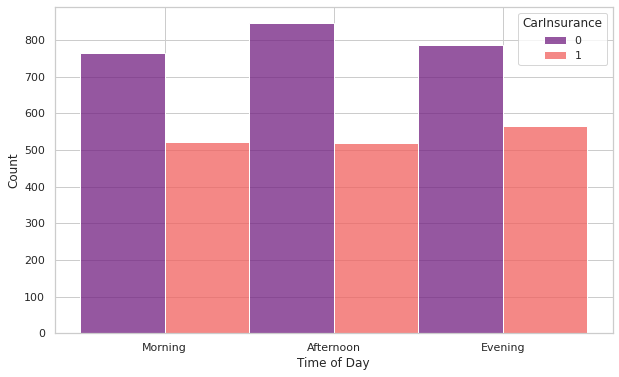

In [74]:
# Plotting how the time of the day affects the likelyhood of subscribing to car insurance
# for different age demographics

plt.figure(figsize=(10,6))
sns.histplot(x='TimeBracket', hue='CarInsurance', data=df_train, multiple="dodge", palette='magma')
plt.ylabel('Count')
plt.xlabel('Time of Day')
plt.show

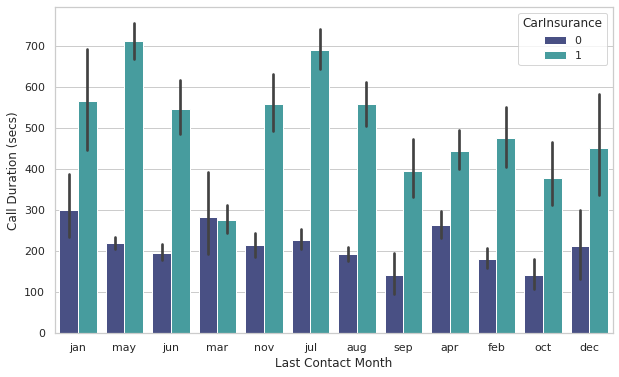

In [75]:
# Plotting how the call duration affects the likelyhood of subscribing to car insurance
# for different months

plt.figure(figsize=(10,6))
sns.barplot(x='LastContactMonth', y='CallDuration', hue='CarInsurance', data=df_train, palette='mako')
plt.ylabel('Call Duration (secs)')
plt.xlabel('Last Contact Month')
plt.show()

# 4. Prepare Data for Machine Learning


In [76]:
#Drop columns used for exploratory analysis
df_train= df_train.drop(['Age'], axis=1)
df_train=df_train.drop(['Balance'], axis=1)
df_train=df_train.drop(['CallStart'], axis=1)
df_train=df_train.drop(['CallEnd'], axis=1)
df_train=df_train.drop(['LastContactDay'], axis=1)
df_train.head()

,Job,Marital,Education,Default,HHInsurance,CarLoan,Communication,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance,CallDuration,BalanceBracket,AgeBracket,DayBracket,TimeBracket
0,management,single,tertiary,0,1,0,telephone,jan,2,-1,0,0,70,Low,31-40,End,Afternoon
1,blue-collar,married,primary,0,1,0,cellular,may,5,-1,0,0,185,Low,31-40,End,Afternoon
2,management,single,tertiary,0,1,0,cellular,jun,1,119,1,1,340,Low,21-30,Start,Evening
3,student,single,primary,0,1,0,cellular,may,2,-1,0,1,819,Low,21-30,Middle,Afternoon
4,management,married,tertiary,0,0,0,cellular,jun,1,-1,0,0,192,High,21-30,Start,Afternoon


In [77]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Job               4000 non-null   object  
 1   Marital           4000 non-null   object  
 2   Education         4000 non-null   object  
 3   Default           4000 non-null   int64   
 4   HHInsurance       4000 non-null   int64   
 5   CarLoan           4000 non-null   int64   
 6   Communication     4000 non-null   object  
 7   LastContactMonth  4000 non-null   object  
 8   NoOfContacts      4000 non-null   int64   
 9   DaysPassed        4000 non-null   int64   
 10  PrevAttempts      4000 non-null   int64   
 11  CarInsurance      4000 non-null   int64   
 12  CallDuration      4000 non-null   int64   
 13  BalanceBracket    4000 non-null   category
 14  AgeBracket        4000 non-null   category
 15  DayBracket        4000 non-null   category
 16  TimeBracket       4000 n

## Encoding categorical values
Machine learning classifiers need numerical values, so category data need to be encoded to numbers before we can fit and evaluate a model.

In [78]:
# Label for category values    
le = LabelEncoder()
    
df_train_cats = df_train.select_dtypes(include=['category']).columns

for i in df_train_cats:
    df_train[i] = le.fit_transform(df_train[i])
    
    
# Apply one-hot encoder to objects
df_train_objs = df_train.select_dtypes(include=['object']).columns

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
train_oh = pd.DataFrame(OH_encoder.fit_transform(df_train[df_train_objs])).astype('int64')

# Get feature columns
train_oh.columns = OH_encoder.get_feature_names(df_train_objs)

# One-hot encoding removed index; put it back
train_oh.index = df_train.index

# Add one-hot encoded columns to our main df 
df_train = pd.concat([df_train, train_oh], axis=1)

df_train = df_train.drop(df_train_objs, axis = 1)

In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Default                  4000 non-null   int64
 1   HHInsurance              4000 non-null   int64
 2   CarLoan                  4000 non-null   int64
 3   NoOfContacts             4000 non-null   int64
 4   DaysPassed               4000 non-null   int64
 5   PrevAttempts             4000 non-null   int64
 6   CarInsurance             4000 non-null   int64
 7   CallDuration             4000 non-null   int64
 8   BalanceBracket           4000 non-null   int64
 9   AgeBracket               4000 non-null   int64
 10  DayBracket               4000 non-null   int64
 11  TimeBracket              4000 non-null   int64
 12  Job_admin.               4000 non-null   int64
 13  Job_blue-collar          4000 non-null   int64
 14  Job_entrepreneur         4000 non-null   int64
 15  Job_

## Update the test set to match the training set

In [80]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1000 non-null   int64  
 1   Age               1000 non-null   int64  
 2   Job               995 non-null    object 
 3   Marital           1000 non-null   object 
 4   Education         953 non-null    object 
 5   Default           1000 non-null   int64  
 6   Balance           1000 non-null   int64  
 7   HHInsurance       1000 non-null   int64  
 8   CarLoan           1000 non-null   int64  
 9   Communication     779 non-null    object 
 10  LastContactDay    1000 non-null   int64  
 11  LastContactMonth  1000 non-null   object 
 12  NoOfContacts      1000 non-null   int64  
 13  DaysPassed        1000 non-null   int64  
 14  PrevAttempts      1000 non-null   int64  
 15  Outcome           243 non-null    object 
 16  CallStart         1000 non-null   object 
 

In [81]:
# A lot of redundant code doing it this way. 
# Tried concatinating the training and test sets at the beginning, but kept having issues.
# For time reasons I just did the test set separately here:

df_test= df_test.drop(['Id'], axis=1)
df_test= df_test.drop(['Outcome'], axis=1)

df_test[['CallStart','CallEnd']]=df_test[['CallStart','CallEnd']].astype('datetime64[ns]')

# Fill NA values with the most common atttribute for each column
for column in ['Job', 'Education','Communication', 'Balance']:
        df_test[column] = df_test[column].fillna(df_test[column].mode()[0])

# Total Call Duration
df_test['CallDuration']=df_test['CallEnd']-df_test['CallStart']

# Extracting the time & converting it to seconds
df_test['CallDuration']=df_test['CallDuration'].dt.components['minutes']*60 + df_test['CallDuration'].dt.components['seconds']

# Redefining the Balance column - removing the outliers
low_bal, upp_bal = remove_outliers(df_test['Balance'])
df_test['Balance']=np.where(df_test['Balance'] > upp_bal, upp_bal, df_test['Balance'])
df_test['Balance']=np.where(df_test['Balance'] < low_bal, low_bal, df_test['Balance'])

# Bins for Balance Bracket
test_bal_bins= [-3000,0,1295,2590,3885]
test_bal_labels = ['Negative Balance','Low','Mid','High']
df_test['BalanceBracket'] = pd.cut(df_test['Balance'], bins=test_bal_bins, labels=test_bal_labels, right=False, include_lowest=True)

# Bins for Age Bracket
test_age_bins= [18,21,31,41,51,61,71,81,91,101]
test_age_labels = ['18-21','21-30','31-40','41-50','51-60','61-70','71-80','81-90', '90+']
df_test['AgeBracket'] = pd.cut(df_test['Age'], bins=test_age_bins, labels=test_age_labels, right=False, include_lowest=True)

# Bins for Day Bracket
test_day_bins= [0,10,21,32]
test_day_labels = ['Start','Middle','End']
df_test['DayBracket'] = pd.cut(df_test['LastContactDay'], bins=test_day_bins, labels=test_day_labels, right=False, include_lowest=True)

# Bins for Time Bracket
df_test['TimeBracket']=pd.cut(df_test["CallStart"].dt.hour,
               [9,12,15,24],
               labels=['Morning','Afternoon','Evening'],
               right=False, include_lowest=True)

# Drop columns used for exploratory analysis
df_test= df_test.drop(['Age'], axis=1)
df_test=df_test.drop(['Balance'], axis=1)
df_test=df_test.drop(['CallStart'], axis=1)
df_test=df_test.drop(['CallEnd'], axis=1)
df_test=df_test.drop(['LastContactDay'], axis=1)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Job               1000 non-null   object  
 1   Marital           1000 non-null   object  
 2   Education         1000 non-null   object  
 3   Default           1000 non-null   int64   
 4   HHInsurance       1000 non-null   int64   
 5   CarLoan           1000 non-null   int64   
 6   Communication     1000 non-null   object  
 7   LastContactMonth  1000 non-null   object  
 8   NoOfContacts      1000 non-null   int64   
 9   DaysPassed        1000 non-null   int64   
 10  PrevAttempts      1000 non-null   int64   
 11  CarInsurance      0 non-null      float64 
 12  CallDuration      1000 non-null   int64   
 13  BalanceBracket    1000 non-null   category
 14  AgeBracket        1000 non-null   category
 15  DayBracket        1000 non-null   category
 16  TimeBracket       1000 no

In [82]:
# Label the category values for Test Set  
test_le = LabelEncoder()
    
df_test_cats = df_train.select_dtypes(include=['category']).columns

for i in df_train_cats:
    df_test[i] = test_le.fit_transform(df_test[i])
    
    
# Apply one-hot encoder to objects for Test Set
df_test_objs = df_test.select_dtypes(include=['object']).columns

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
test_oh = pd.DataFrame(OH_encoder.fit_transform(df_test[df_test_objs])).astype('int64')

# Get feature column
test_oh.columns = OH_encoder.get_feature_names(df_test_objs)

# One-hot encoding removed index; put it back
test_oh.index = df_test.index

# Add one-hot encoded columns to our main df
df_test = pd.concat([df_test, test_oh], axis=1)

df_test = df_test.drop(df_test_objs, axis = 1)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Default                  1000 non-null   int64  
 1   HHInsurance              1000 non-null   int64  
 2   CarLoan                  1000 non-null   int64  
 3   NoOfContacts             1000 non-null   int64  
 4   DaysPassed               1000 non-null   int64  
 5   PrevAttempts             1000 non-null   int64  
 6   CarInsurance             0 non-null      float64
 7   CallDuration             1000 non-null   int64  
 8   BalanceBracket           1000 non-null   int64  
 9   AgeBracket               1000 non-null   int64  
 10  DayBracket               1000 non-null   int64  
 11  TimeBracket              1000 non-null   int64  
 12  Job_admin.               1000 non-null   int64  
 13  Job_blue-collar          1000 non-null   int64  
 14  Job_entrepreneur         

## Split training set

X is used for the features
y for CarInsurance (this is the target value we want to predict)

The Train Test split is of a 80:20 ratio respectively.

In [83]:
X=df_train.drop(['CarInsurance'],axis=1).values
# Including only the Target for y
y=df_train['CarInsurance'].values

#Splitting the Training and Testing data having 20% of Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42, stratify = y)

## Define a function that will plot a confusion matrix for each classifier

# 5. Machine Learning Classifiers

In [84]:
# This confusion matrix was sourced from the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
      
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    # Show all ticks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Loop over data dimensions 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")       
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
class_names = ['Success','Failure']

## K-Nearest Neighbour

Best parameters:  {'n_neighbors': 7, 'p': 1, 'weights': 'distance'} 

kNN Accuracy: 0.79
Cross Validation Score: 0.77
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       479
           1       0.77      0.70      0.73       321

    accuracy                           0.79       800
   macro avg       0.79      0.78      0.78       800
weighted avg       0.79      0.79      0.79       800



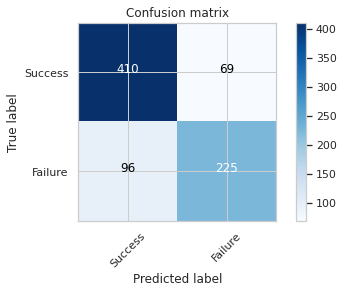

In [85]:
knn = KNeighborsClassifier()

# Use GridSearchCV to search over parameter values for the estimator
# This takes some time to run so can always be scaled back
parameters = {'n_neighbors':[5,6,7,8], 
              'p':[1,2],
              'weights':['uniform','distance']}

knn_clf = GridSearchCV(knn, parameters)
knn_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", knn_clf.best_params_, '\n')

# Accuracy
print ("kNN Accuracy: %2.2f" % accuracy_score(y_test, knn_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_knn = cross_val_score(knn_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_knn)

# Prediction
y_pred= knn_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix for K-Nearest Neighbour
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

## Logistic Regression Classifier

Best parameters:  {'C': 0.8} 

Logistic Accuracy: 0.81
Cross Validation Score: 0.80
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       479
           1       0.79      0.71      0.74       321

    accuracy                           0.81       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.81      0.80       800



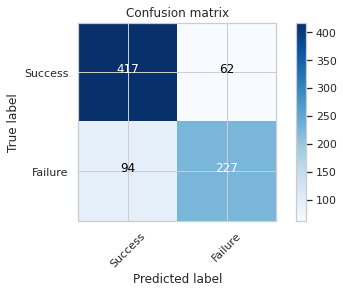

In [86]:
LR = LogisticRegression(max_iter=1500)

# Use GridSearchCV
parameters = {'C':[0.7,0.8,0.9,1]}

lr_clf = GridSearchCV(LR, parameters)
lr_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", lr_clf.best_params_, '\n')

# Accuracy
print ("Logistic Accuracy: %2.2f" % accuracy_score(y_test, lr_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_LR = cross_val_score(lr_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_LR)

# Prediction
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix for Logistical Regression
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

## Decision Tree Classifier

Best parameters:  {'class_weight': None, 'max_depth': 6, 'min_weight_fraction_leaf': 0.01} 

Decision Tree Accuracy: 0.81
Cross Validation Score: 0.79 

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       479
           1       0.79      0.71      0.75       321

    accuracy                           0.81       800
   macro avg       0.81      0.79      0.80       800
weighted avg       0.81      0.81      0.81       800



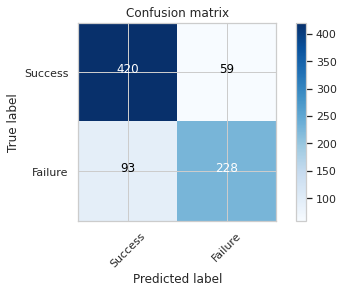

In [87]:
DT = tree.DecisionTreeClassifier(random_state=21, criterion='gini')

# Use GridSearchCV
parameters = {'class_weight':[None,'balanced'],
              'min_weight_fraction_leaf':[0.0,0.01],
              'max_depth':[None,6,8,9]}

dt_clf = GridSearchCV(DT, parameters)
dt_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", dt_clf.best_params_,'\n')

# Accuracy
print ("Decision Tree Accuracy: %2.2f" % accuracy_score(y_test, dt_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_DT = cross_val_score(dt_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_DT, "\n")

# Prediction
y_pred = dt_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix for Decision Tree
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

## Random Forest Classifier

Best parameters:  {'min_samples_split': 12} 

Random Forest Accuracy: 0.84
Cross Validation Score: 0.82
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       479
           1       0.82      0.76      0.79       321

    accuracy                           0.84       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.84      0.84       800



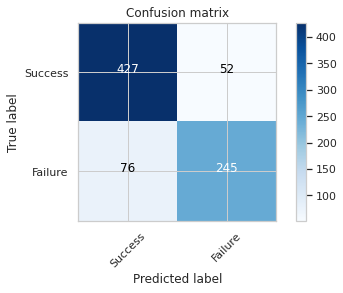

In [88]:
rfc = RandomForestClassifier(n_estimators=1000, criterion='gini', class_weight=None, max_depth=8, min_samples_leaf=3)

# Use GridSearchCV
parameters = {'min_samples_split': [8, 10, 12]}

rfc_clf = GridSearchCV(rfc, parameters)
rfc_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", rfc_clf.best_params_, '\n')

# Accuracy
print ("Random Forest Accuracy: %2.2f" % accuracy_score(y_test, rfc_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_rfc = cross_val_score(rfc_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_rfc)

# Prediction
y_pred = rfc_clf.predict(X_test)
print(classification_report(y_test,y_pred ))

# Confusion Matrix for Random Forest
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

## AdaBoost Classifier

Best parameters:  {'learning_rate': 0.15} 

AdaBoost Accuracy: 0.83
Cross Validation Score: 0.82
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       479
           1       0.81      0.75      0.78       321

    accuracy                           0.83       800
   macro avg       0.82      0.81      0.82       800
weighted avg       0.83      0.83      0.83       800



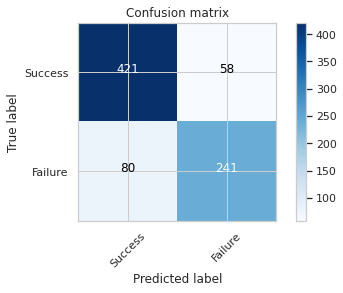

In [43]:
ada = AdaBoostClassifier(random_state=21, n_estimators=500)

# Use GridSearchCV
parameters = {'learning_rate': [0.05,0.1,0.15]}

ada_clf = GridSearchCV(ada, parameters)
ada_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", ada_clf.best_params_, '\n')

# Accuracy
print ("AdaBoost Accuracy: %2.2f" % accuracy_score(y_test,ada_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_ada = cross_val_score(ada_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_ada)

# Make prediction
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test,y_pred ))

# Confusion Marix for AdaBoost
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

## XGBoost Classifier

Best parameters:  {'subsample': 0.8} 

GradientBoost Accuracy: 0.82
Cross Validation Score: 0.82
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       479
           1       0.79      0.75      0.77       321

    accuracy                           0.82       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.82      0.82      0.82       800



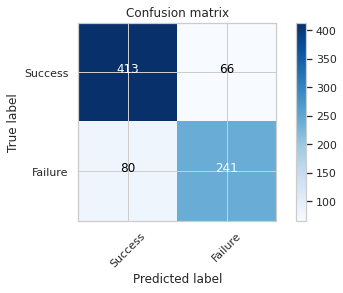

In [89]:
xgb = GradientBoostingClassifier(random_state=21, n_estimators=1000, max_depth=8, learning_rate=0.15)

# Use GridSearchCV
parameters = {'subsample':[0.8,0.9,1]}

xgb_clf = GridSearchCV(xgb, parameters)
xgb_clf.fit(X_train,y_train)

# Get best parameters
print("Best parameters: ", xgb_clf.best_params_, '\n')

# Accuracy
print ("GradientBoost Accuracy: %2.2f" % accuracy_score(y_test,xgb_clf.predict(X_test)))

# Evaluate score (10-fold cross validation)
score_xgb = cross_val_score(xgb_clf, X_train, y_train, cv=10).mean()
print("Cross Validation Score: %2.2f" % score_ada)

# Prediction
y_pred = xgb_clf.predict(X_test) 
print(classification_report(y_test,y_pred))

# Confusion Matrix for XGBoost
cm_xg = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm_xg, classes=class_names, title='Confusion matrix')

## ROC Curves for each classifier

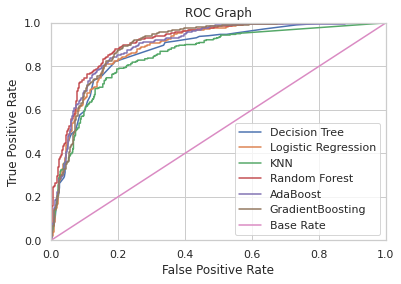

In [91]:
# False Positive Rate, True Positive Rate and Threshold for classifiers
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn_clf.predict_proba(X_test)[:,1])
LR_fpr, LR_tpr, thresholds = roc_curve(y_test, lr_clf.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, dt_clf.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc_clf.predict_proba(X_test)[:,1])
ada_fpr, ada_tpr, thresholds = roc_curve(y_test, ada_clf.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:,1])

# Plotting ROC Curves for all classifiers
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(knn_fpr, knn_tpr, label='KNN' )
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(ada_fpr, ada_tpr, label='AdaBoost')
plt.plot(xgb_fpr, xgb_tpr, label='GradientBoosting')

# Plot Base Rate ROC
plt.plot([0,1],[0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

# 6. Testing the Trained Model
Use the best two classifers -- Random Forest and XGBoost -- on the test data (CarInsurance_test.csv)

In [93]:
#Random Forest Classifier
rfc.fit(X_train,y_train)
X_test = df_test.drop("CarInsurance", axis = 1)
df_test["CarInsurance"] = rfc.predict(X_test)
df_test["CarInsurance"] = df_test["CarInsurance"].apply(lambda x: "No. that will not buy insurance [0]" if x==0 else "No. that will buy insurance [1]")
df_test["CarInsurance"].value_counts()

No. that will not buy insurance [0]    602
No. that will buy insurance [1]        398
Name: CarInsurance, dtype: int64

In [94]:
#XGBoost Classifier
xgb.fit(X_train,y_train)
X_test = df_test.drop("CarInsurance", axis = 1)
df_test["CarInsurance"] = xgb.predict(X_test)
df_test["CarInsurance"] = df_test["CarInsurance"].apply(lambda x: "No that will not buy insurance [0]" if x==0 else "No. that will buy insurance [1]")
df_test["CarInsurance"].value_counts()

No that will not buy insurance [0]    594
No. that will buy insurance [1]       406
Name: CarInsurance, dtype: int64